<a href="https://colab.research.google.com/github/AhmadAbubakarAhmadA/SPEOPF_W25/blob/main/pheno_boundary_colab_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pheno-Boundary: FTW Model Inference on GPU

**Run this notebook on Google Colab with GPU enabled (T4)**

This notebook:
1. Loads preprocessed FTW inputs from local machine
2. Downloads FTW model weights
3. Runs inference on GPU
4. Saves results for local analysis

---

## Setup GPU Runtime

**Before running**: Runtime → Change runtime type → GPU (T4)

In [1]:
# Verify GPU is available
import torch

if torch.cuda.is_available():
    print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"  GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠ No GPU detected. Go to Runtime → Change runtime type → GPU")

✓ GPU available: Tesla T4
  GPU memory: 15.8 GB


## 1. Install Dependencies

In [2]:
!pip install -q segmentation-models-pytorch timm

import numpy as np
import pickle
import os

print("✓ Dependencies installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.3 MB/s eta 0:00:00
✓ Dependencies installed


## 2. Upload FTW Inputs

Upload the `ftw_inputs.pkl` file you saved locally

In [4]:
from google.colab import drive
from google.colab import files
import pickle
import os

drive.mount('/content/drive')

# Load ftw_inputs
file_path = '/content/drive/MyDrive/pheno-boundary/data/outputs/ftw_inputs.pkl'

print("Loading pre-saved data...")
with open(file_path, 'rb') as f:
      ftw_inputs = pickle.load(f)

print(f"✓ Loaded {len(ftw_inputs)} years of preprocessed data")
for year, data in ftw_inputs.items():
    print(f"  {year}: shape {data.shape}, range [{data.min():.3f}, {data.max():.3f}]")

print("\n✓ Skipping datacube loading - using saved preprocessed inputs")
print("✓ Ready for model inference!")

Mounted at /content/drive
Loading pre-saved data...
✓ Loaded 4 years of preprocessed data
  2020: shape (8, 368, 177), range [0.021, 1.000]
  2021: shape (8, 368, 177), range [0.021, 1.000]
  2022: shape (8, 368, 177), range [0.017, 1.000]
  2023: shape (8, 368, 177), range [0.020, 1.000]

✓ Skipping datacube loading - using saved preprocessed inputs
✓ Ready for model inference!


## 3. Download FTW Model

In [5]:
import urllib.request
import os

# Define model directory
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

model_url = "https://github.com/fieldsoftheworld/ftw-baselines/releases/download/v3.1/prue_efnetb3_ccby_checkpoint.ckpt"
model_path = os.path.join(model_dir, "prue_efnetb3_ccby_checkpoint.ckpt")

if not os.path.exists(model_path):
    print("Downloading FTW model (~50 MB)...")
    urllib.request.urlretrieve(model_url, model_path)
    print(f"✓ Downloaded to {model_path}")
else:
    print(f"✓ Model exists: {model_path}")

✓ Downloaded to models/prue_efnetb3_ccby_checkpoint.ckpt


## 4. Load FTW Model

In [6]:
import segmentation_models_pytorch as smp

class FTWInference:
    def __init__(self, checkpoint_path, device='cuda'):
        self.device = torch.device(device)

        self.model = smp.Unet(
            encoder_name="efficientnet-b3",
            encoder_weights=None,
            in_channels=8,
            classes=3,
        )

        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        state_dict = checkpoint.get('state_dict', checkpoint)
        state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}

        self.model.load_state_dict(state_dict, strict=False)
        self.model.to(self.device)
        self.model.eval()

        print(f"✓ Model loaded on {self.device}")

    def predict(self, input_array):
        input_tensor = torch.from_numpy(input_array).unsqueeze(0).to(self.device)

        with torch.no_grad():
            logits = self.model(input_tensor)
            probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

        return {
            'field_prob': probs[1],
            'boundary_prob': probs[2],
            'class_map': np.argmax(probs, axis=0),
            'field_mask': probs[1] > 0.5,
        }

# Initialize model
ftw_model = FTWInference(model_path, device='cuda')

✓ Model loaded on cuda


## 5. Run Inference

In [7]:
ftw_results = {}

for year in sorted(ftw_inputs.keys()):
    print(f"{year}...", end=" ")
    results = ftw_model.predict(ftw_inputs[year])
    ftw_results[year] = results
    field_pct = 100 * results['field_mask'].sum() / results['field_mask'].size
    print(f"✓ {field_pct:.1f}% field coverage")

print(f"\n✓ Inference complete for {len(ftw_results)} years")

2020... ✓ 0.0% field coverage
2021... ✓ 0.0% field coverage
2022... ✓ 0.0% field coverage
2023... ✓ 13.6% field coverage

✓ Inference complete for 4 years


## 6. Save Results

In [8]:
# Save results
with open('ftw_results.pkl', 'wb') as f:
    pickle.dump(ftw_results, f)

print("✓ Results saved to ftw_results.pkl")

# Download results
files.download('ftw_results.pkl')

print("\n✓ Download started. Save this file to continue analysis locally.")

✓ Results saved to ftw_results.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Download started. Save this file to continue analysis locally.


## 7. Preview Results

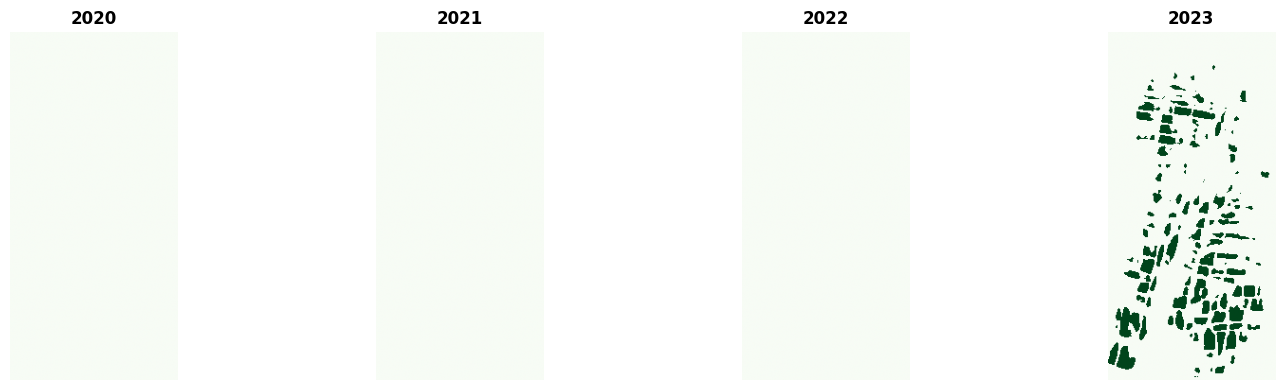

✓ Field masks preview


In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(ftw_results), figsize=(4*len(ftw_results), 4))
if len(ftw_results) == 1:
    axes = [axes]

for idx, year in enumerate(sorted(ftw_results.keys())):
    axes[idx].imshow(ftw_results[year]['field_mask'], cmap='Greens')
    axes[idx].set_title(f'{year}', fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("✓ Field masks preview")

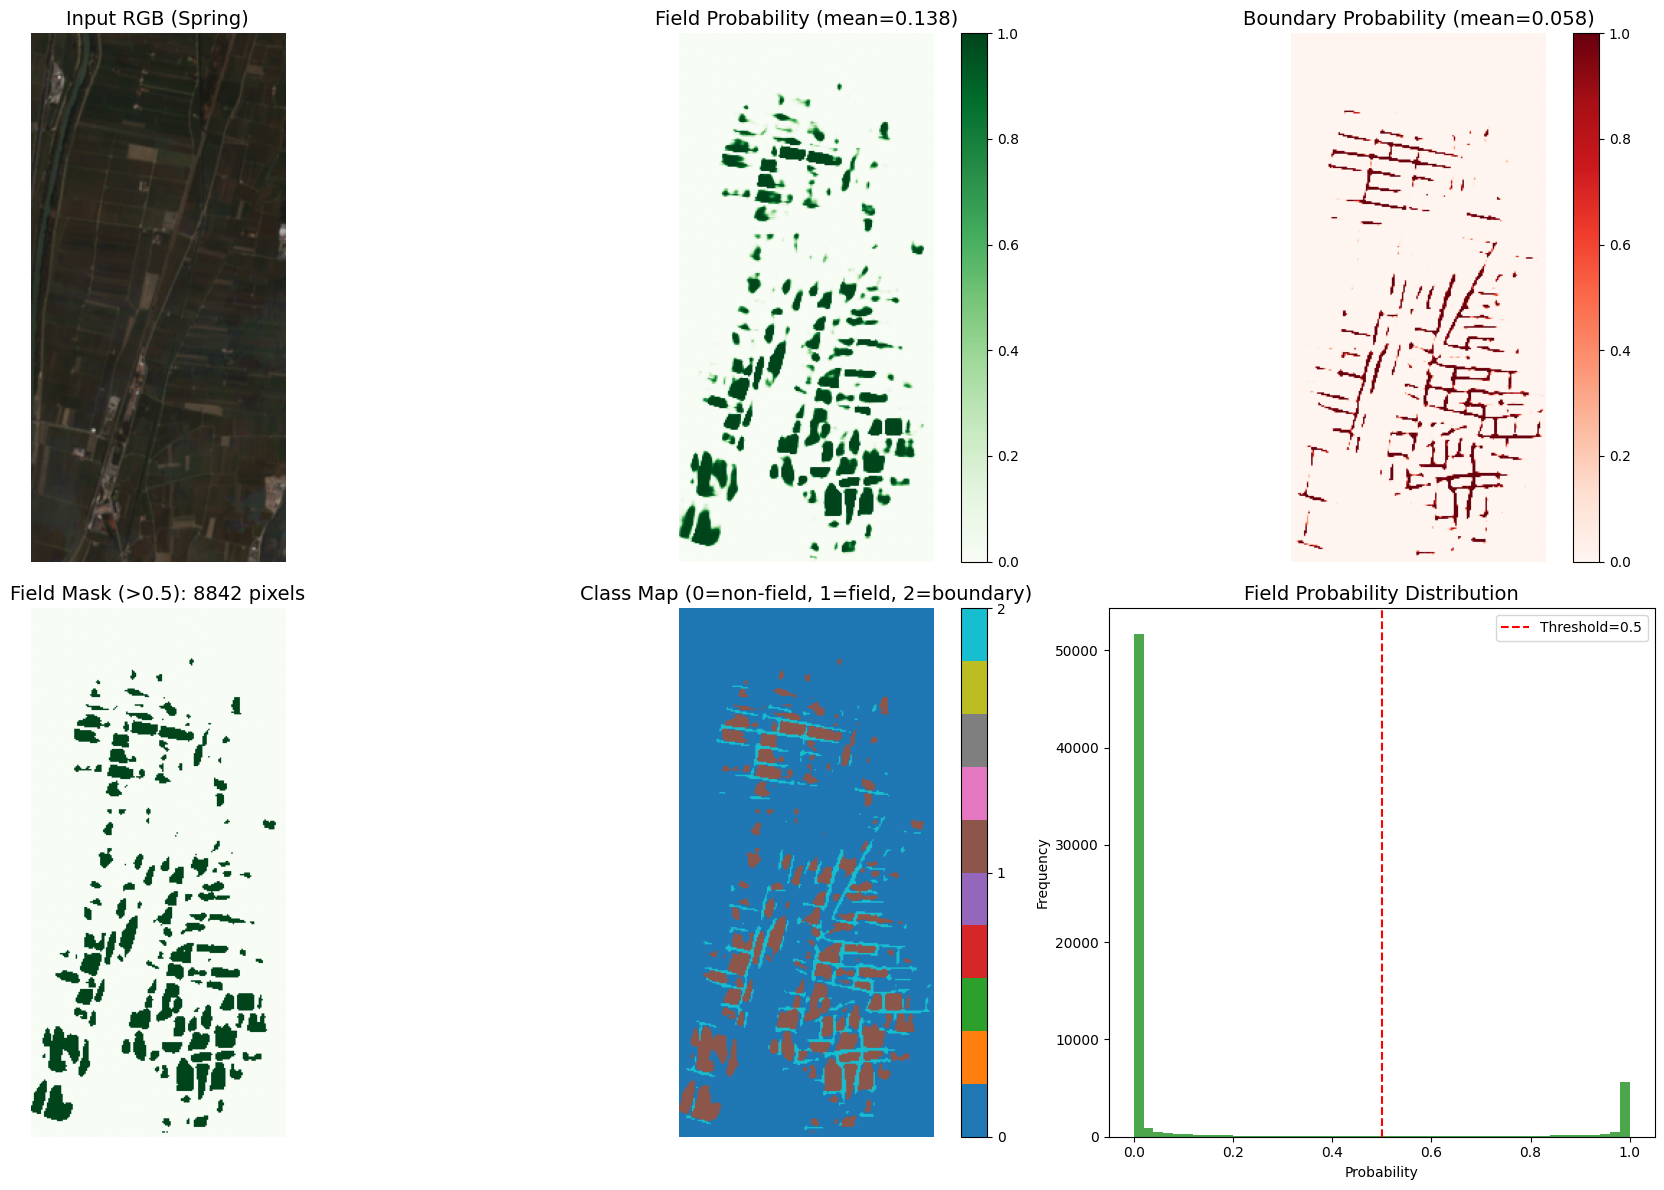


Field probability statistics:
  Min: 0.0000
  Mean: 0.1380
  Median: 0.0000
  Max: 1.0000
  Pixels > 0.5: 8842 (13.6%)
  Pixels > 0.3: 9706 (14.9%)


In [10]:
# Visualize predictions for one year
import matplotlib.pyplot as plt

year = 2023  # The one that had some detections
results = ftw_results[year]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original RGB composite (from spring)
rgb_spring = ftw_inputs[year][[2,1,0], :, :]  # B04, B03, B02 (RGB)
rgb_spring_vis = np.transpose(rgb_spring, (1, 2, 0))
axes[0, 0].imshow(rgb_spring_vis)
axes[0, 0].set_title('Input RGB (Spring)', fontsize=14)
axes[0, 0].axis('off')

# Field probability
im1 = axes[0, 1].imshow(results['field_prob'], cmap='Greens', vmin=0, vmax=1)
axes[0, 1].set_title(f"Field Probability (mean={results['field_prob'].mean():.3f})", fontsize=14)
axes[0, 1].axis('off')
plt.colorbar(im1, ax=axes[0, 1])

# Boundary probability
im2 = axes[0, 2].imshow(results['boundary_prob'], cmap='Reds', vmin=0, vmax=1)
axes[0, 2].set_title(f"Boundary Probability (mean={results['boundary_prob'].mean():.3f})", fontsize=14)
axes[0, 2].axis('off')
plt.colorbar(im2, ax=axes[0, 2])

# Field mask (threshold > 0.5)
axes[1, 0].imshow(results['field_mask'], cmap='Greens')
axes[1, 0].set_title(f"Field Mask (>0.5): {results['field_mask'].sum()} pixels", fontsize=14)
axes[1, 0].axis('off')

# Class map
im3 = axes[1, 1].imshow(results['class_map'], cmap='tab10', vmin=0, vmax=2)
axes[1, 1].set_title('Class Map (0=non-field, 1=field, 2=boundary)', fontsize=14)
axes[1, 1].axis('off')
plt.colorbar(im3, ax=axes[1, 1], ticks=[0, 1, 2])

# Histogram of field probabilities
axes[1, 2].hist(results['field_prob'].flatten(), bins=50, alpha=0.7, color='green')
axes[1, 2].set_title('Field Probability Distribution', fontsize=14)
axes[1, 2].set_xlabel('Probability')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].axvline(0.5, color='red', linestyle='--', label='Threshold=0.5')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

print(f"\nField probability statistics:")
print(f"  Min: {results['field_prob'].min():.4f}")
print(f"  Mean: {results['field_prob'].mean():.4f}")
print(f"  Median: {np.median(results['field_prob']):.4f}")
print(f"  Max: {results['field_prob'].max():.4f}")
print(f"  Pixels > 0.5: {(results['field_prob'] > 0.5).sum()} ({100*(results['field_prob'] > 0.5).mean():.1f}%)")
print(f"  Pixels > 0.3: {(results['field_prob'] > 0.3).sum()} ({100*(results['field_prob'] > 0.3).mean():.1f}%)")

In [11]:
# Check model loading warnings
print("Checking model structure...")
print(f"Model device: {ftw_model.device}")
print(f"Model training mode: {ftw_model.model.training}")

# Check if weights actually loaded
checkpoint = torch.load(model_path, map_location='cpu')
print(f"\nCheckpoint keys: {checkpoint.keys()}")

if 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
    print(f"Number of parameters in checkpoint: {len(state_dict)}")
    print(f"First 5 keys: {list(state_dict.keys())[:5]}")
else:
    print("No 'state_dict' key found - using checkpoint directly")

Checking model structure...
Model device: cuda
Model training mode: False

Checkpoint keys: dict_keys(['pytorch-lightning_version', 'state_dict', 'hyper_parameters'])
Number of parameters in checkpoint: 634
First 5 keys: ['model.encoder._conv_stem.weight', 'model.encoder._bn0.weight', 'model.encoder._bn0.bias', 'model.encoder._bn0.running_mean', 'model.encoder._bn0.running_var']


In [12]:
# Check input statistics
print("Input data verification:")
for year in sorted(ftw_inputs.keys()):
    data = ftw_inputs[year]
    print(f"\n{year}:")
    print(f"  Shape: {data.shape}")
    print(f"  Dtype: {data.dtype}")
    print(f"  Range: [{data.min():.4f}, {data.max():.4f}]")
    print(f"  Mean: {data.mean():.4f}")
    print(f"  Has NaN: {np.isnan(data).any()}")
    print(f"  Has Inf: {np.isinf(data).any()}")

    # Check each channel
    for i in range(8):
        ch_name = ['B02_spring', 'B03_spring', 'B04_spring', 'B08_spring',
                   'B02_summer', 'B03_summer', 'B04_summer', 'B08_summer'][i]
        print(f"    {ch_name}: mean={data[i].mean():.4f}, std={data[i].std():.4f}")

Input data verification:

2020:
  Shape: (8, 368, 177)
  Dtype: float32
  Range: [0.0210, 1.0000]
  Mean: 0.2736
  Has NaN: False
  Has Inf: False
    B02_spring: mean=0.1533, std=0.0398
    B03_spring: mean=0.1876, std=0.0445
    B04_spring: mean=0.1935, std=0.0493
    B08_spring: mean=0.6820, std=0.1307
    B02_summer: mean=0.0753, std=0.0494
    B03_summer: mean=0.1205, std=0.0540
    B04_summer: mean=0.0951, std=0.0662
    B08_summer: mean=0.6816, std=0.1536

2021:
  Shape: (8, 368, 177)
  Dtype: float32
  Range: [0.0214, 1.0000]
  Mean: 0.2623
  Has NaN: False
  Has Inf: False
    B02_spring: mean=0.1159, std=0.0492
    B03_spring: mean=0.1645, std=0.0497
    B04_spring: mean=0.1850, std=0.0561
    B08_spring: mean=0.6396, std=0.1247
    B02_summer: mean=0.0886, std=0.0515
    B03_summer: mean=0.1310, std=0.0574
    B04_summer: mean=0.1082, std=0.0708
    B08_summer: mean=0.6654, std=0.1424

2022:
  Shape: (8, 368, 177)
  Dtype: float32
  Range: [0.0172, 1.0000]
  Mean: 0.2382
  H